In [1]:
from __future__ import print_function
from astropy.io import fits
from astropy.table import Table
from pathlib import Path
import numpy as np
import pandas as pd
np.set_printoptions(threshold=np.inf)


import os
import sys
sys.path.append("/Users/kack0001/astro-tools/github/Zernike/ppln/lib/")
import glob
import subprocess
import shutil
import math
import numpy as np

from astropy import wcs
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
from scipy.spatial import KDTree

from ppln_tools import ppln_misc
from ppln_tools import ppln_zernike
from ppln_tools import ppln_classes
from ppln_tools import ppln_fileIO

## Generate the PSF model

Here we look at the reference image we'll use for generating the PSF model `PTF_d004916_f02_c04_u000150868_p12-refimg.fits` file in the `img_path`. This assumes we have an already generated catalog named `PTF_d004916_f02_c04_u000150868_p12-refimg.cat.fits` returned from Source Extractor. If not you can create one with the example images using the command:

```sex example/PTF_d005363_f02_c10_u000139561_p12_refimg.fits -c ppln/param/example.sex -CATALOG_NAME example/PTF_d005363_f02_c10_u000139561_p12_refimg.cat.fits```

```sex example/PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10.fits -c ppln/param/example.sex -CATALOG_NAME example/PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10.cat.fits```

For running the final subtracted image through Source Extractor, add in an additional argument to **NOT** filter as we want all sources from the image, or 

```sex example/PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10_sub.fits -c ppln/param/example.sex -CATALOG_NAME example/PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10_sub.cat.fits -FILTER N```

We filter the objects by flux and near edges. Those that pass our checks, we generate the model using Singular Value Decomposition onto a set of Zernike Polynomials and then write to file.

['/Users/kack0001/astro-tools/github/Zernike/example/PTF_d005363_f02_c10_u000139561_p12_refimg.fits']
/Users/kack0001/astro-tools/github/Zernike/example/PTF_d005363_f02_c10_u000139561_p12_refimg.fits
4796  objects found in image catalog.
1021.5357513427734 175.41211318969727
4796
2279 objects successfully Zernike decomposed, compiling statistics...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


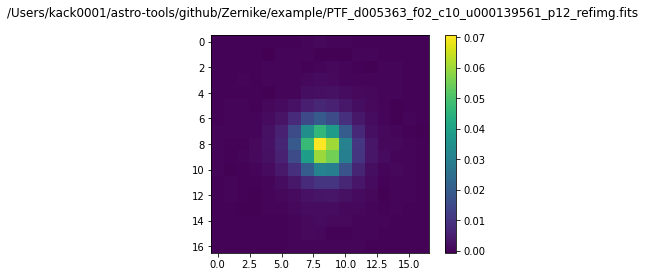

Writing PSF statistics to file


In [2]:
img_path = '/Users/kack0001/astro-tools/github/Zernike/example/'
psf_path = '/Users/kack0001/astro-tools/github/Zernike/example/'


if not os.path.exists(psf_path):
    os.makedirs(psf_path)


# img_files = glob.glob(img_path+'*')
img_files = [img_path+'PTF_d005363_f02_c10_u000139561_p12_refimg.fits']
print(img_files)

###############################################################################

disk_dim    = 17
disk_rad    = 8.5
sub_dim     = 27
nz_max      = 49
z_ord       = range(1,nz_max+1)
psf_stamp_dim = 27

zern_list_0,disk_mask_0 = ppln_zernike.create_fzern_list(z_ord,disk_dim,disk_rad,0.0,0.0,21)
cov_mat_inv_0           = ppln_zernike.inv_cov_mat(zern_list_0)


###############################################################################
# Parameters for psf composition

flux_min    =   5000 #5.0e3
flux_max    =   80000 #3e5
cls_min     =   0.001
cls_max     =   1.0
flag_req    =   0

###############################################################################

def filter_cat_xy(cat_list,img_shape,sub_dim):

    x_min = (sub_dim+1)/2
    x_max = img_shape[1]-x_min
    y_min = (sub_dim+1)/2
    y_max = img_shape[0]-y_min
    print('X AND Y: ',x_min,x_max,y_min,y_max)
    filter_list = []
    for cat_item in cat_list:
        if (x_min < cat_item['XWIN_IMAGE'] < x_max and y_min < cat_item['YWIN_IMAGE'] < y_max):
            filter_list.append(cat_item)
    return(filter_list)

###############################################################################

for img_file in img_files:
    print(img_file)

    cat_file = str(Path(img_file).with_suffix('.cat.fits'))
    psf_file = str(Path(img_file).with_suffix('.psf'))
    img = fits.open(img_file,ignore_missing_end=True)
    # Double check extensions
    img_data = img[0].data
    img_head = img[0].header
    img.close()

    img_shape = img_data.shape

    cat_list = Table(fits.open(cat_file)[1].data).to_pandas()
    cat_list['XWIN_IMAGE'] = cat_list['XWIN_IMAGE'] - 1.0
    cat_list['YWIN_IMAGE'] = cat_list['YWIN_IMAGE'] - 1.0
    print(str(len(cat_list))," objects found in image catalog.")
    catflux = cat_list['FLUX_AUTO']
    flux_max = np.quantile(catflux,0.75)
    flux_min = np.quantile(catflux,0.05)
    print(flux_max,flux_min)

    x_min = (sub_dim+1)/2
    x_max = img_shape[1]-x_min
    y_min = (sub_dim+1)/2
    y_max = img_shape[0]-y_min

    cat_filter = cat_list[(x_min < cat_list['XWIN_IMAGE']) & (cat_list['XWIN_IMAGE'] < x_max) & (y_min < cat_list['YWIN_IMAGE'])& (cat_list['YWIN_IMAGE'] < y_max)]

    cat_filter['dx'] = cat_filter.XWIN_IMAGE.astype(int) - cat_filter.XWIN_IMAGE
    cat_filter['dy'] = cat_filter.YWIN_IMAGE.astype(int) - cat_filter.YWIN_IMAGE
    print(len(cat_filter))

    wf_s_coeff_list = []

    for index, cat_item in cat_filter.iterrows():
        sys.stdout.write("Catalog Number %d   \r" % (index) )
        sys.stdout.flush()
        #disk_rad = 3*2*cat_item.r  #3xFWHM, where FWHM = 2*flux_radius
        x_int = cat_item.XWIN_IMAGE.astype(int)
        y_int = cat_item.YWIN_IMAGE.astype(int)

        sub_img = ppln_misc.sub_image(img_data,x_int,y_int,sub_dim)
        sub_img = ppln_misc.remove_background(sub_img)
        sub_img_s = ppln_misc.shift_image(sub_img,cat_item.dx,cat_item.dy,5)
        wf_s_img = ppln_misc.calc_wavefront(sub_img_s,disk_mask_0)
        wf_s_coeff = ppln_zernike.zern_fit(wf_s_img,zern_list_0,cov_mat_inv_0)
        wf_s_rec = ppln_zernike.wf_comp_brief(wf_s_coeff,zern_list_0)
        wf_s_err = ppln_zernike.calc_wf_error(wf_s_img,wf_s_rec,disk_mask_0)
        if wf_s_err < .01:
            wf_s_coeff_list.append(wf_s_coeff)

    print(str(len(wf_s_coeff_list)) + " objects successfully Zernike decomposed, compiling statistics...")

    wf_s_coeff_list = np.array(wf_s_coeff_list)

    wf_s_coeff_mean = np.mean(wf_s_coeff_list,axis=0)
    wf_s_coeff_mean_std = np.std(wf_s_coeff_list,axis=0)

    try: # raises IndexError: index -1 is out of bounds for axis 0 with size 0 because wf_s_coeff_list = 0
        wf_s_coeff_med = np.median(wf_s_coeff_list,axis=0)
        passed = 1
    except IndexError:
        passed = 0
        pass

    if passed:
        wf_s_coeff_med_std = np.zeros(len(wf_s_coeff_med))

        if len(wf_s_coeff_list)>2:
            for k in range(len(wf_s_coeff_med)):
                for l in range(len(wf_s_coeff_list)):
                    wf_s_coeff_med_std[k] += (wf_s_coeff_list[l][k]-wf_s_coeff_med[k])**2
                wf_s_coeff_med_std[k] = np.sqrt(wf_s_coeff_med_std[k])

            n_bins = int(math.floor(10*math.log10(len(wf_s_coeff_list))))

        n_bins = int(math.floor(10*math.log10(len(wf_s_coeff_list))))
        if not n_bins:
            n_bins = int(3.0)
        try:
            gfit_res                = ppln_misc.gfit_zerndist(wf_s_coeff_list,n_bins)
            wf_s_coeff_gauss        = np.array(gfit_res[0])
            wf_s_coeff_gauss_std    = np.array(gfit_res[1])
            wf_s_coeff_gauss_chi2   = np.array(gfit_res[2])
        except (RuntimeError):
            pass
            wf_s_coeff_gauss             = np.array([-99.0]*nz_max)
            wf_s_coeff_gauss_std         = np.array([-99.0]*nz_max)
            wf_s_coeff_gauss_chi2        = np.array([-99.0]*nz_max)

        wf_mask = np.copy(disk_mask_0)

        tile_cent = cat_filter[(cat_filter['dx'] <0.5) & (cat_filter['dx'] >-0.5) & (cat_filter['dy'] <0.5) & (cat_filter['dy'] >-0.5)]
        wf_list = []
        for index, cat_item in tile_cent.iterrows():
            wf_list.append(ppln_misc.img2wf(img_data,cat_item.XWIN_IMAGE,cat_item.YWIN_IMAGE,psf_stamp_dim,wf_mask))
        psf_wf_tile = np.zeros((1,1,disk_dim,disk_dim))
        wf_mean1 = np.nanmean(np.array(wf_list),axis=0)
        wf_mean1 = wf_mean1/np.sum(wf_mean1)
        wf_errs1 = [np.nanstd(wf_mean1-wf) for wf in wf_list]
        wf_std1 = np.sqrt(np.nansum([wf_err**2 for wf_err in wf_errs1])/len(wf_errs1))
        wf_list_clean1 = [wf_item for wf_item in wf_list if np.nanstd(wf_item-wf_mean1)<3.0*wf_std1]

        wf_mean2 = np.mean(wf_list_clean1,axis=0)
        wf_mean2 = wf_mean2/np.sum(wf_mean2)
        wf_errs2 = [np.std(wf_mean2-wf) for wf in wf_list_clean1]
        wf_std2 = np.sqrt(np.sum([wf_err**2 for wf_err in wf_errs2])/len(wf_errs2))
        wf_list_clean2 = [wf_item for wf_item in wf_list_clean1 if np.std(wf_item-wf_mean2)<3.0*wf_std2]

        wf_mean3 = np.mean(wf_list_clean2,axis=0)
        wf_mean3 = wf_mean3/np.sum(wf_mean3)
        wf_errs3 = [np.std(wf_mean3-wf) for wf in wf_list_clean2]
        wf_std3 = np.sqrt(np.sum([wf_err**2 for wf_err in wf_errs3])/len(wf_errs3))
        wf_list_clean3 = [wf_item for wf_item in wf_list_clean2 if np.std(wf_item-wf_mean3)<3.0*wf_std3]

        wf_weights = [1/np.var(wf_item) for wf_item in wf_list_clean3]
        try:
            wf_avg = np.average(wf_list_clean3,axis=0,weights=wf_weights)*wf_mask
        except ZeroDivisionError:
            wf_avg = np.average(wf_list_clean3,axis=0)*wf_mask
        psf_wf_tile = wf_avg/wf_avg.sum()

        psf_inj = np.array(psf_wf_tile,copy=True)

        plot = 1
        if plot:
            fig = plt.figure()
            plt.suptitle(img_file)
            plt.imshow(psf_inj)
            plt.colorbar()
            plt.savefig(str(Path(psf_file).with_suffix('.png')))
            plt.show()
            plt.close()

    ###############################################################################

        print("Writing PSF statistics to file")
        with open(psf_file, 'w') as psfID:
            psfID.write("# Source list compiled from "+img_file+" using catalog file "+cat_file+".\n")
            psfID.write("# Parameters for source selection were flux_min=%5.3f and cls_min=%1.3f.\n" % (flux_min, cls_min))
            psfID.write("# %4g of %5g catalog objects Z-decomposed up to nz=%2g.\n" % (len(wf_s_coeff_list), len(cat_filter), nz_max))
            psfID.write("# Dimensions of subimages are surr_dim: %2g and disk_dim: %2g.\n" % (sub_dim, disk_dim))
            psfID.write("# %2g\tSURR_DIM\n" % sub_dim)
            psfID.write("# %2g\tDISK_DIM\n" % disk_dim)
            psfID.write("# %2g\tDISK_RAD\n" % disk_rad)
            psfID.write("# %2g\tJ_MAX\n" % nz_max)
            psfID.write("# 0 \tZ_ORD\tZERNIKE ORDER\n")
            psfID.write("# 1 \tMEAN\tMEAN OF DISTRIBUTION\n")
            psfID.write("# 2 \tMN_SD\tSTANDARD DEVIATION WRT MEAN OF DISTRIBUTION\n")
            psfID.write("# 3 \tMED\t\tMEDIAN OF DISTRIBUTION\n")
            psfID.write("# 4 \tMD_SD\tSTANDARD DEVIATION WRT MEDIAN OF DISTRIBUTION\n")
            psfID.write("# 5 \tGAUSS\tCENTER OF GAUSSIAN FIT\n")
            psfID.write("# 6 \tGS_SD\tSTANDARD DEVIATION OF GAUSSIAN FIT\n")
            psfID.write("# 7 \tCHI2\tCHI^2 OF GAUSSIAN FIT\n")
            for k in range(len(wf_s_coeff_mean)):
                psfID.write("%2g" % k)
                psfID.write("\t%+10.8f" % wf_s_coeff_mean[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_mean_std[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_med[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_med_std[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_gauss[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_gauss_std[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_gauss_chi2[k])
                psfID.write("\n")
            psfID.close()

    else:
        wf_s_coeff_mean = np.array([0.0]*nz_max)
        wf_s_coeff_mean_std = np.array([0.0]*nz_max)
        wf_s_coeff_med = np.array([0.0]*nz_max)
        wf_s_coeff_med_std = np.array([0.0]*nz_max)
        wf_s_coeff_gauss = np.array([-99.0]*nz_max)
        wf_s_coeff_gauss_std = np.array([-99.0]*nz_max)
        wf_s_coeff_gauss_chi2 = np.array([-99.0]*nz_max)

        print("Writing PSF statistics to file")
        with open(psf_path+psf_file, 'w') as psfID:
            psfID.write("# Source list compiled from "+img_file+" using catalog file "+cat_file+".\n")
            psfID.write("# Parameters for source selection were flux_min=%5.3f and cls_min=%1.3f.\n" % (flux_min, cls_min))
            psfID.write("# %4g of %5g catalog objects Z-decomposed up to nz=%2g.\n" % (len(wf_s_coeff_list), len(cat_filter), nz_max))
            psfID.write("# Dimensions of subimages are surr_dim: %2g and disk_dim: %2g.\n" % (sub_dim, disk_dim))
            psfID.write("# %2g\tSURR_DIM\n" % sub_dim)
            psfID.write("# %2g\tDISK_DIM\n" % disk_dim)
            psfID.write("# %2g\tDISK_RAD\n" % disk_rad)
            psfID.write("# %2g\tJ_MAX\n" % nz_max)
            psfID.write("# 0 \tZ_ORD\tZERNIKE ORDER\n")
            psfID.write("# 1 \tMEAN\tMEAN OF DISTRIBUTION\n")
            psfID.write("# 2 \tMN_SD\tSTANDARD DEVIATION WRT MEAN OF DISTRIBUTION\n")
            psfID.write("# 3 \tMED\t\tMEDIAN OF DISTRIBUTION\n")
            psfID.write("# 4 \tMD_SD\tSTANDARD DEVIATION WRT MEDIAN OF DISTRIBUTION\n")
            psfID.write("# 5 \tGAUSS\tCENTER OF GAUSSIAN FIT\n")
            psfID.write("# 6 \tGS_SD\tSTANDARD DEVIATION OF GAUSSIAN FIT\n")
            psfID.write("# 7 \tCHI2\tCHI^2 OF GAUSSIAN FIT\n")
            for k in range(nz_max):
                psfID.write("%2g" % k)
                psfID.write("\t%+10.8f" % wf_s_coeff_mean[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_mean_std[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_med[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_med_std[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_gauss[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_gauss_std[k])
                psfID.write("\t%+10.8f" % wf_s_coeff_gauss_chi2[k])
                psfID.write("\n")
            psfID.close()
        
        

## Generate transient catalog with ZDIST values 

In the following code block we calculate the ZD scores for all sources in the difference image using the reference PSF model that we generated above. In this example the reference PSF is `reference_2minute_tmpl.psf`. We read in the subtracted image catalog (that we assume that this is not already generated). If it has already been generated change `uselocal` to True.

In [5]:
tbl

NUMBER,XWIN_IMAGE,YWIN_IMAGE,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,FLUX_BEST,FLUXERR_BEST,FLUX_RADIUS,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,FWHM_IMAGE,FLAGS,CLASS_STAR
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32
1,171.23690542083017,36.25692894600442,1786.632,70.282684,-8.130088,0.042721163,1786.632,70.282684,1.1122779,172.1407,35.01513,160.6470920892196,82.07288540501726,4.668291,0,0.9981204
2,1153.571633445561,75.68379343342518,514.0022,62.681873,-6.7774124,0.13243623,514.0022,62.681873,1.2039268,1153.9542,75.682144,162.62958742915006,82.03721044463575,4.7498045,0,0.38804007
3,927.2476758498755,114.1203784765555,-55.130356,110.20376,99.0,99.0,7943.051,111.49889,0.5660569,927.2477,114.12038,162.1640391643622,82.03289285303168,7.6122236,3,0.980997
4,1401.6674322863435,89.46363789294747,1171.1581,55.494297,-7.671539,0.051459156,1171.1581,55.494297,1.0066007,1387.5098,94.962166,163.09609689203668,82.02466507596706,3.1318016,0,0.9554524
5,1378.4756453852874,98.18891077098138,1960.6884,100.984764,-8.231022,0.055934157,1960.6884,100.984764,1.5849111,1378.5443,98.69873,163.07719119185262,82.02390521821097,7.520073,2,0.25805786
6,1382.0204057222845,90.2594482023876,787.71045,63.883312,-7.2409167,0.088074595,787.71045,63.883312,1.1330667,1381.582,89.58115,163.08539812950508,82.02635675191644,4.7571907,16,0.8561289
7,923.97611844426,105.99795704385716,330.42996,192.9389,-6.2976985,0.6341182,330.42996,192.9389,0.73598784,924.4648,105.51087,162.16012057933278,82.0353788061335,14.667915,18,0.98315036
8,1384.6012566384525,97.08990113848456,263.22983,68.56066,-6.0508375,0.28285882,5135.6694,77.39512,0.20653035,1384.1372,96.87992,163.088867060346,82.02423622603384,5.004292,3,0.99903864
9,917.6128440620679,119.1595147479388,1296.7599,122.43628,-7.782149,0.10253695,1296.7599,122.43628,1.1141087,919.9833,117.13602,162.14877831609087,82.03224653243896,9.333633,2,0.98392886


In [18]:
uselocal = False
sys.stdout.write("Reading pipeline parameters ... ")
sys.stdout.flush()

img_path = '/Users/kack0001/astro-tools/github/Zernike/example/'
cat_path = '/Users/kack0001/astro-tools/github/Zernike/example/'
psf_path = '/Users/kack0001/astro-tools/github/Zernike/example/'


if not os.path.exists(cat_path):
    os.makedirs(cat_path)
if not os.path.exists(psf_path):
    os.makedirs(psf_path)

rep_img_path = img_path 
rep_psf_path = psf_path

sub_img_path = '/Users/kack0001/astro-tools/github/Zernike/example/' 
sub_cat_path = '/Users/kack0001/astro-tools/github/Zernike/example/'

sub_transient_path = '/Users/kack0001/astro-tools/github/Zernike/example/'
if not os.path.exists(sub_transient_path):
    os.makedirs(sub_transient_path)

dz_max = 5000
disk_dim = 17
disk_rad = 8.5
sub_dim = 27
nz_max = 49
z_ord = range(1,nz_max+1)
psf_stamp_dim = 27

sys.stdout.write("Done\n")

sys.stdout.write("Calculating Zernike basis ... ")
sys.stdout.flush()
j_vec = range(1,nz_max+1)
zern_list,disk_mask = ppln_zernike.create_fzern_list(j_vec,disk_dim,disk_rad,0.0,0.0,21)
cov_mat_inv = ppln_zernike.inv_cov_mat(zern_list)
sys.stdout.write("Done\n")

sub_img_files = [os.path.basename(x) for x in glob.glob(sub_img_path+'*sub.fits')]

for sub_img_file in sub_img_files:
    print(sub_img_file)
    t=1 #transient_flag for writing out transient file
    sys.stdout.write("Performing Zernike analysis of file "+sub_img_path+sub_img_file+" \n")
    
    filename = Path(sub_img_file)
    sub_cat_file = str(filename.with_suffix('.cat.fits'))
    s_trans_file    = str(filename.with_suffix('.trans')) 
    s_trans_reg     = str(filename.with_suffix('.reg')) 

    ref_psf_file = 'PTF_d005363_f02_c10_u000139561_p12_refimg.psf'

    sys.stdout.write("Reading subtracted image and catalog ... ")
    sys.stdout.flush()
    zern_stats,_,_,_,_    = ppln_fileIO.read_zern_file(rep_psf_path+ref_psf_file)

    sub         = fits.open(sub_img_path+sub_img_file)
    sub_data    = sub[0].data
    sub_head    = sub[0].header
    sub.close()
    
    img_shape = sub_data.shape
    x_min       = (sub_dim+1)/2
    x_max       = img_shape[1]-x_min
    y_min       = (sub_dim+1)/2
    y_max       = img_shape[0]-y_min
    

    tbl = Table(fits.getdata(sub_img_path+sub_cat_file))
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    sub_cat = tbl[names].to_pandas()
    sub_cat_filter = sub_cat[(x_min < sub_cat['XWIN_IMAGE']) & (sub_cat['XWIN_IMAGE'] < x_max) & (y_min < sub_cat['YWIN_IMAGE'])& (sub_cat['YWIN_IMAGE'] < y_max)]

    print(str(len(sub_cat))," objects found in image catalog.")
   
    sys.stdout.write("Done\n")

    sys.stdout.write("Performing Zernike decompositions ...")
    sys.stdout.flush()
    trans_list  = []
    
    for index, cand_item in sub_cat_filter.iterrows():
        x           = cand_item.XWIN_IMAGE
        y           = cand_item.YWIN_IMAGE
        wf_s_img    = ppln_misc.img2wf_lanczos3(sub_data,x,y,sub_dim,disk_mask)
        wf_s_coeff  = ppln_zernike.zern_fit(wf_s_img,zern_list,cov_mat_inv)
        wf_s_rec    = ppln_zernike.wf_comp_brief(wf_s_coeff,zern_list)
        wf_s_err    = ppln_zernike.calc_wf_error(wf_s_img,wf_s_rec,disk_mask)
        wf_s_z_dist = ppln_misc.calc_zdist_med_std(wf_s_coeff,zern_stats)

        x = cand_item.XWIN_IMAGE
        y = cand_item.YWIN_IMAGE
        flux = cand_item.FLUX_AUTO
        flux_err = cand_item.FLUXERR_AUTO
        snr = flux/flux_err
        ra = cand_item.ALPHA_J2000
        dec = cand_item.DELTA_J2000
        mag_app = cand_item.MAG_AUTO
        mag_app_err = cand_item.MAGERR_AUTO
        zpt = 24.
        mag_inst = mag_app + zpt
        zpt_err = 0
        mag_inst_err = np.sqrt(mag_app_err**2+zpt_err**2)

        if wf_s_z_dist < dz_max:
            trans_list.append(ppln_classes.trans_obj(x,y,snr,wf_s_z_dist,mag_inst,mag_inst_err,ra,dec,flux,flux_err,mag_app,mag_app_err))

    with open(sub_transient_path+s_trans_file, 'w') as transID:
        transID.write("# Zernike Distance: \t%5g\n" %dz_max)
        transID.write("# Number of objects in subtracted image: \t%5g\n" %len(sub_cat))
        transID.write("# Number of transient objects detected: \t%5g\n" %len(trans_list))
        transID.write("# 0 \tNUMBER\n")
        transID.write("# 1 \tX_COORD\n")
        transID.write("# 2 \tY_COORD\n")
        transID.write("# 3 \tSNR\n")
        transID.write("# 4 \tZ_DIST\n")
        transID.write("# 5 \tMAG_INST\n")
        transID.write("# 6 \tMAG_INST_ERR\n")
        transID.write("# 7 \tRA\n")
        transID.write("# 8 \tDEC\n")
        transID.write("# 9 \tFLUX\n")
        transID.write("# 10 \tFLUX_ERR\n")
        transID.write("# 11 \tMAG_APP\n")
        transID.write("# 12 \tMAG_APP_ERR\n")

        for i,trns_item in enumerate(trans_list):
            transID.write("%4g" % i)
            transID.write("\t%11.6f" % trns_item.x)
            transID.write("\t%11.6f" % trns_item.y)
            transID.write("\t%6.2f"  % trns_item.snr)
            transID.write("\t%6.2f"  % trns_item.z_dist)
            transID.write("\t%10.6f" % trns_item.mag_inst)
            transID.write("\t%10.6f" % trns_item.mag_inst_err)
            transID.write("\t%12.6f" % trns_item.ra)
            transID.write("\t%12.6f" % trns_item.dec)
            transID.write("\t%10.6f" % trns_item.flux)
            transID.write("\t%10.6f" % trns_item.flux_err)
            transID.write("\t%10.6f" % trns_item.mag_app)
            transID.write("\t%10.6f" % trns_item.mag_app_err)
            transID.write("\n")
    transID.close()

    print('Writing Region File')
    with open(sub_transient_path+s_trans_reg, 'w') as regID:
        regID.write("# Region file format: DS9 version 4.1\n")
        regID.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        regID.write("image\n")
        for i,trns_item in enumerate(trans_list):
            if trns_item.z_dist < 13:
                transient_x = trns_item.x
                transient_y = trns_item.y
                regID.write('circle(%s,%s,12.8744)' % (transient_x,transient_y))
                regID.write("\n")
#             else:
#                 transient_x = trns_item.x
#                 transient_y = trns_item.y
#                 regID.write('circle(%s,%s,12.8744) # color=red' % (transient_x,transient_y))
#                 regID.write("\n")
    regID.close()

sys.stdout.write("Done\n")
sys.stdout.write("Finished Zernike PSF analysis for all images\n")


Reading pipeline parameters ... Done
Calculating Zernike basis ... Done
PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10_sub.fits
Performing Zernike analysis of file /Users/kack0001/astro-tools/github/Zernike/example/PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10_sub.fits 
Reading subtracted image and catalog ... 8092  objects found in image catalog.
Done
Performing Zernike decompositions ...Writing Region File
Done
Finished Zernike PSF analysis for all images


## Notes
You can open up the image in ds9 and load in the region file to make sure that the ZD threshold (`if trns_item.z_dist < 13`) makes sense for your image.

## Working with noninjections -- aka actual images

Use this block if you are not comparing the detections against an injection set. This will plot the ZDIST distribution for the non-injection set.

/Users/kack0001/astro-tools/github/Zernike/example/PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10_sub.trans
PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10_sub.trans


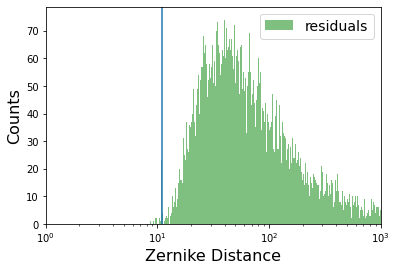

57


In [9]:
#NON INJECTIONS
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

trans_files = [os.path.basename(x) for x in glob.glob(sub_transient_path+'*.trans')]

num_inj = 0
num_sub = 0

trans_cum_list  = []
azdistsnoninj_all = []

names =  ['NUMBER', 'X_COORD', 'Y_COORD', 'SNR', 'Z_DIST', 'MAG_INST', 'MAG_INST_ERR', 'RA', 'DEC', 'FLUX', 'FLUX_ERR', 'MAG_APP', 'MAG_APP_ERR']

trans_cum_list_filt_all = []
azdists_all = []
for trans_file in trans_files:
    print(sub_transient_path+trans_file)
    azdistsnoninj = []
    trans_cum_list_filt = []
    trans_list = pd.read_csv(sub_transient_path+trans_file,names=names,delimiter='\t',comment='#')

    print(trans_file)
    
    tt = 11
    for tindx, trans_item in trans_list.iterrows():
        azdistsnoninj.append(trans_item.Z_DIST)
        
        trans_cum_list.append(trans_item)
        if trans_item.Z_DIST < tt:
            trans_cum_list_filt.append(trans_item[['X_COORD','Y_COORD','Z_DIST','RA','DEC']].values )
    trans_cum_list_filt_all.append(trans_cum_list_filt)
            
    


    plt.figure(1)
    plt.hist(azdistsnoninj,bins=np.logspace(np.log10(1.0), np.log10(5000.0), 500),alpha = 0.5, label='residuals',edgecolor='None',color='g')
    plt.xlabel('Zernike Distance', fontsize=16)

    plt.xlim(1.0,1000.0)
    plt.gca().set_xscale("log")
    plt.axvline(tt)
    plt.ylabel('Counts', fontsize=16)
    plt.legend(loc='upper right',prop={'size':14})
    plt.show()



    artlist = [(a <= tt) for a in azdistsnoninj]
    azdistsnoninj_all.append([(a <= tt) for a in azdistsnoninj].count(1))
    azdists_all.append(azdistsnoninj)

    fp = artlist.count(1)
    tn = artlist.count(0)
    print([(a <= tt) for a in azdistsnoninj].count(1))

In [29]:
threshold = np.linspace(0,4999,5000)
roc = np.zeros((5000,2))

auc = 0.

for ii in range(5000):
    t = threshold[ii]

    injlist = [(i <= t) for i in i_zdists_re]
    artlist = [(a <= t) for a in a_zdists_re]
    tp = injlist.count(1)
    fn = injlist.count(0)
    fp = artlist.count(1)
    tn = artlist.count(0)

    try:
        fpr = fp / float(fp + tn)
        tpr = tp / float(tp + fn)
    except ZeroDivisionError:
        fpr = np.NaN
        tpr = np.NaN

    roc[ii,0] = fpr
    roc[ii,1] = tpr

    auc += (roc[ii,0]-roc[ii-1,0]) * (roc[ii,1] + roc[ii-1,1])
auc *= 0.5

plt.figure(2)
plt.plot(roc[:,0],roc[:,1],lw=2,label='AUC_2min = %.4f' % (auc,))
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.xlabel('$FPR$')
plt.ylabel('$TPR$')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.legend(loc='lower right',prop={'size':10})
plt.title('ROC Curve')#, AUC = %.4f' % auc)
plt.grid()
plt.show()

NameError: name 'i_zdists_re' is not defined

## The following code block is how it will eventually work. There are bugs that need to be fixed so for now, this is only an example of the future structure. 

In [ ]:
from zernike import zernike
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import pandas as pd
from scipy.spatial import KDTree, cKDTree
import pickle
path = '/Users/kack0001/astro-tools/github/Zernike/example/'
inpath = path
catpath= path+'test/'
outpath = path+'test/'
psfpath = path+'test/'
transpath = path+'test/'
parampath = '/Users/kack0001/astro-tools/github/Zernike/example/zernike/param/'
config = parampath + 'param_evry_file.ini'


inimage = 'PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10.fits'
refimage = 'PTF_d005363_f02_c10_u000139561_p12_refimg.fits'
subimage = 'PTF_201202254903_i_p_scie_t114605_u012167055_f02_p005363_c10_sub.fits'
SExtractor_condition = 'test'


In [ ]:
z = zernike.Shapelet(inimage=inimage,refimage=refimage,refpath=inpath,subpath=inpath,config=config,
                     subimage=subimage,inpath=inpath,parampath=parampath,psfpath=psfpath,
                     catpath=catpath,transpath=transpath,outpath=outpath,
                     nthreads=1,verbose=True, align=0,wcs_flag=0,subtract=0)

z.main()